# 07. PyTorch Experiment Tracking

> **Note:** This notebook uses `torchvision`'s new [multi-weight support API (available in `torchvision` v0.13+)](https://pytorch.org/blog/introducing-torchvision-new-multi-weight-support-api/).

We've trained a fair few models now on the journey to making FoodVision Mini (an image classification model to classify images of pizza, steak or sushi).

And so far we've kept track of them via Python dictionaries.

Or just comparing them by the metric print outs during training.

What if you wanted to run a dozen (or more) different models at once?

Surely there's a better way...

There is.

**Experiment tracking.**

And since experiment tracking is so important and integral to machine learning, you can consider this notebook your first milestone project.

So welcome to Milestone Project 1: FoodVision Mini Experiment Tracking.

We're going to answer the question: **how do I track my machine learning experiments?**


## What is experiment tracking?

Machine learning and deep learning are very experimental.

You have to put on your artist's beret/chef's hat to cook up lots of different models.

And you have to put on your scientist's coat to track the results of various combinations of data, model architectures and training regimes.

That's where **experiment tracking** comes in.

If you're running lots of different experiments, **experiment tracking helps you figure out what works and what doesn't**.


## Why track experiments?

If you're only running a handful of models (like we've done so far), it might be okay just to track their results in print outs and a few dictionaries.

However, as the number of experiments you run starts to increase, this naive way of tracking could get out of hand.

So if you're following the machine learning practitioner's motto of _experiment, experiment, experiment!_, you'll want a way to track them.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/07-experiment-tracking-can-get-out-of-hand.png" alt="experiment tracking can get out of hand, many different experiments with different names" width=900/>

_After building a few models and tracking their results, you'll start to notice how quickly it can get out of hand._


## Different ways to track machine learning experiments

There are as many different ways to track machine learning experiments as there are experiments to run.

This table covers a few.

| **Method**                                                                        | **Setup**                                                                     | **Pros**                                                                     | **Cons**                                                                 | **Cost**              |
| --------------------------------------------------------------------------------- | ----------------------------------------------------------------------------- | ---------------------------------------------------------------------------- | ------------------------------------------------------------------------ | --------------------- |
| Python dictionaries, CSV files, print outs                                        | None                                                                          | Easy to setup, runs in pure Python                                           | Hard to keep track of large numbers of experiments                       | Free                  |
| [TensorBoard](https://www.tensorflow.org/tensorboard/get_started)                 | Minimal, install [`tensorboard`](https://pypi.org/project/tensorboard/)       | Extensions built into PyTorch, widely recognized and used, easily scales.    | User-experience not as nice as other options.                            | Free                  |
| [Weights & Biases Experiment Tracking](https://wandb.ai/site/experiment-tracking) | Minimal, install [`wandb`](https://docs.wandb.ai/quickstart), make an account | Incredible user experience, make experiments public, tracks almost anything. | Requires external resource outside of PyTorch.                           | Free for personal use |
| [MLFlow](https://mlflow.org/)                                                     | Minimal, install `mlflow` and start tracking                                  | Fully open-source MLOps lifecycle management, many integrations.             | Little bit harder to setup a remote tracking server than other services. | Free                  |

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/07-different-places-to-track-experiments.png" alt="various places to track machine learning experiments" width=900/>

_Various places and techniques you can use to track your machine learning experiments. **Note:** There are various other options similar to Weights & Biases and open-source options similar to MLflow but I've left them out for brevity. You can find more by searching "machine learning experiment tracking"._


## What we're going to cover

We're going to be running several different modelling experiments with various levels of data, model size and training time to try and improve on FoodVision Mini.

And due to its tight integration with PyTorch and widespread use, this notebook focuses on using TensorBoard to track our experiments.

However, the principles we're going to cover are similar across all of the other tools for experiment tracking.

| **Topic**                                                  | **Contents**                                                                                                                                                                                           |
| ---------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **0. Getting setup**                                       | We've written a fair bit of useful code over the past few sections, let's download it and make sure we can use it again.                                                                               |
| **1. Get data**                                            | Let's get the pizza, steak and sushi image classification dataset we've been using to try and improve our FoodVision Mini model's results.                                                             |
| **2. Create Datasets and DataLoaders**                     | We'll use the `data_setup.py` script we wrote in chapter 05. PyTorch Going Modular to setup our DataLoaders.                                                                                           |
| **3. Get and customise a pretrained model**                | Just like the last section, 06. PyTorch Transfer Learning we'll download a pretrained model from `torchvision.models` and customise it to our own problem.                                             |
| **4. Train model and track results**                       | Let's see what it's like to train and track the training results of a single model using TensorBoard.                                                                                                  |
| **5. View our model's results in TensorBoard**             | Previously we visualized our model's loss curves with a helper function, now let's see what they look like in TensorBoard.                                                                             |
| **6. Creating a helper function to track experiments**     | If we're going to be adhering to the machine learner practitioner's motto of _experiment, experiment, experiment!_, we best create a function that will help us save our modelling experiment results. |
| **7. Setting up a series of modelling experiments**        | Instead of running experiments one by one, how about we write some code to run several experiments at once, with different models, different amounts of data and different training times.             |
| **8. View modelling experiments in TensorBoard**           | By this stage we'll have run eight modelling experiments in one go, a fair bit to keep track of, let's see what their results look like in TensorBoard.                                                |
| **9. Load in the best model and make predictions with it** | The point of experiment tracking is to figure out which model performs the best, let's load in the best performing model and make some predictions with it to _visualize, visualize, visualize!_.      |


## 0. Getting setup


In [1]:
import torch 
from torch import nn
import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt
from going_modular import data_setup, engine, GPU_check

device = GPU_check.GPU_check()
device

CUDA available: True
CUDA devices: 1
Current device: 0
Device name: NVIDIA GeForce RTX 3060 Laptop GPU


'cuda'

## 1. Get data

we can rewrite the same function that downloads the data and unzips it but i just copied the data folder from the other chapter..,


In [2]:
import os
import zipfile

from pathlib import Path

import requests

def download_data(source: str, 
                destination: str,
                remove_source: bool = True) -> Path:
    # sourcery skip: extract-method
    """Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.
    
    Returns:
        pathlib.Path to downloaded data.
    
    Example usage:
        download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                    destination="pizza_steak_sushi")
    """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it... 
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)
        
        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...") 
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)
    
    return image_path

# image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
#                         destination="pizza_steak_sushi")
# image_path

## 2. Create Datasets and DataLoaders

Now we've got some data, let's turn it into PyTorch DataLoaders.

We can do so using the `create_dataloaders()` function we created in [05. PyTorch Going Modular part 2](https://www.learnpytorch.io/05_pytorch_going_modular/#2-create-datasets-and-dataloaders-data_setuppy).

And since we'll be using transfer learning and specifically pretrained models from [`torchvision.models`](https://pytorch.org/vision/stable/models.html), we'll create a transform to prepare our images correctly.

To transform our images into tensors, we can use:

1. Manually created transforms using `torchvision.transforms`.
2. Automatically created transforms using `torchvision.models.MODEL_NAME.MODEL_WEIGHTS.DEFAULT.transforms()`.
   - Where `MODEL_NAME` is a specific `torchvision.models` architecture, `MODEL_WEIGHTS` is a specific set of pretrained weights and `DEFAULT` means the "best available weights".

We saw an example of each of these in [06. PyTorch Transfer Learning section 2](https://www.learnpytorch.io/06_pytorch_transfer_learning/#2-create-datasets-and-dataloaders).

Let's see first an example of manually creating a `torchvision.transforms` pipeline (creating a transforms pipeline this way gives the most customization but can potentially result in performance degradation if the transforms don't match the pretrained model).

The main manual transformation we need to be sure of is that all of our images are normalized in ImageNet format (this is because pretrained `torchvision.models` are all pretrained on [ImageNet](https://www.image-net.org/)).

We can do this with:

```python
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
```


### 2.1 Create DataLoaders using manually created transforms


In [3]:
from pathlib import Path

# Setup path to data folder
DATA_PATH = Path("data/")
IMG_PATH = DATA_PATH / "pizza_steak_sushi"
    
# Set up directories
TRAIN_PATH = IMG_PATH/ "train"
TEST_PATH = IMG_PATH/ "test"

norm = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])

manual_trans = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    norm
])

print(f"Manually created transforms: {manual_trans}")

# Create data loaders
train_loader, test_loader, class_names = data_setup.create_dataloader(TRAIN_PATH, TEST_PATH,
                                            manual_trans, 32)

train_loader, test_loader, class_names

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


(<torch.utils.data.dataloader.DataLoader at 0x20df3c7a2c0>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Create DataLoaders using automatically created transforms

Data transformed and DataLoaders created!

Let's now see what the same transformation pipeline looks like but this time by using automatic transforms.

We can do this by first instantiating a set of pretrained weights (for example `weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT`) we'd like to use and calling the `transforms()` method on it.


In [4]:
# Setup pretrained weights (plenty of these available in torchvision.models)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# Get transforms from weights (these are the transforms that were used to obtain the weights)
auto_trans = weights.transforms()

print(f"Manually created transforms: {auto_trans}")

# Create data loaders
train_loader, test_loader, class_names = data_setup.create_dataloader(TRAIN_PATH, TEST_PATH,
                                            auto_trans, 32)

train_loader, test_loader, class_names

Manually created transforms: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


(<torch.utils.data.dataloader.DataLoader at 0x20df3c7aec0>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model, freezing the base layers and changing the classifier head

Before we run and track multiple modelling experiments, let's see what it's like to run and track a single one.

And since our data is ready, the next thing we'll need is a model.

Let's download the pretrained weights for a `torchvision.models.efficientnet_b0()` model and prepare it for use with our own data.


In [5]:
# Download the pretrained weights for EfficientNet_B0
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # NEW in torchvision 0.13, "DEFAULT" means "best weights available"

# Setup the model with the pretrained weights and send it to the target device
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

# View the output of the model
# model

Wonderful!

Now we've got a pretrained model let's turn it into a feature extractor model.

In essence, we'll freeze the base layers of the model (we'll use these to extract features from our input images) and we'll change the classifier head (output layer) to suit the number of classes we're working with (we've got 3 classes: pizza, steak, sushi).

> **Note:** The idea of creating a feature extractor model (what we're doing here) was covered in more depth in [06. PyTorch Transfer Learning section 3.2: Setting up a pretrained model](https://www.learnpytorch.io/06_pytorch_transfer_learning/#32-setting-up-a-pretrained-model).


In [6]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [7]:
# Freeze all feature layers by setting requires_grad attribute to False
for param in model.features.parameters():
    param.requires_grad = False
    

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=3, bias=True)
).to(device)

In [8]:
from torchinfo import summary

# Get a summary of the model (uncomment for full output)
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## 4. Train model and track results

Model ready to go!

Let's get ready to train it by creating a loss function and an optimizer.

Since we're working with multiple classes, we'll use [`torch.nn.CrossEntropyLoss()`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) as the loss function.

And we'll stick with [`torch.optim.Adam()`](https://pytorch.org/docs/stable/optim.html) with learning rate of `0.001` for the optimizer.


In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Adjust `train()` function to track results with `SummaryWriter()`

Beautiful!

All of the pieces of our training code are starting to come together.

Let's now add the final piece to track our experiments.

Previously, we've tracked our modelling experiments using multiple Python dictionaries (one for each model).

But you can imagine this could get out of hand if we were running anything more than a few experiments.

Not to worry, there's a better option!

We can use PyTorch's [`torch.utils.tensorboard.SummaryWriter()`](https://pytorch.org/docs/stable/tensorboard.html) class to save various parts of our model's training progress to file.

By default, the `SummaryWriter()` class saves various information about our model to a file set by the `log_dir` parameter.

The default location for `log_dir` is under `runs/CURRENT_DATETIME_HOSTNAME`, where the `HOSTNAME` is the name of your computer.

But of course, you can change where your experiments are tracked (the filename is as customisable as you'd like).

The outputs of the `SummaryWriter()` are saved in [TensorBoard format](https://www.tensorflow.org/tensorboard/).

TensorBoard is a part of the TensorFlow deep learning library and is an excellent way to visualize different parts of your model.

To start tracking our modelling experiments, let's create a default `SummaryWriter()` instance.


In [10]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()
writer

### Adjust `train()` function to track results with `SummaryWriter()`

Beautiful!

All of the pieces of our training code are starting to come together.

Let's now add the final piece to track our experiments.

Previously, we've tracked our modelling experiments using multiple Python dictionaries (one for each model).

But you can imagine this could get out of hand if we were running anything more than a few experiments.

Not to worry, there's a better option!

We can use PyTorch's [`torch.utils.tensorboard.SummaryWriter()`](https://pytorch.org/docs/stable/tensorboard.html) class to save various parts of our model's training progress to file.

By default, the `SummaryWriter()` class saves various information about our model to a file set by the `log_dir` parameter.

The default location for `log_dir` is under `runs/CURRENT_DATETIME_HOSTNAME`, where the `HOSTNAME` is the name of your computer.

But of course, you can change where your experiments are tracked (the filename is as customisable as you'd like).

The outputs of the `SummaryWriter()` are saved in [TensorBoard format](https://www.tensorflow.org/tensorboard/).

TensorBoard is a part of the TensorFlow deep learning library and is an excellent way to visualize different parts of your model.

To start tracking our modelling experiments, let's create a default `SummaryWriter()` instance.

Now to use the writer, we could write a new training loop or we could adjust the existing `train()` function we created in [05. PyTorch Going Modular section 4](https://www.learnpytorch.io/05_pytorch_going_modular/#4-creating-train_step-and-test_step-functions-and-train-to-combine-them).

Let's take the latter option.

We'll get the `train()` function from [`engine.py`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/going_modular/engine.py) and adjust it to use `writer`.

Specifically, we'll add the ability for our `train()` function to log our model's training and test loss and accuracy values.

We can do this with [`writer.add_scalars(main_tag, tag_scalar_dict)`](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_scalars), where:

- `main_tag` (string) - the name for the scalars being tracked (e.g. "Accuracy")
- `tag_scalar_dict` (dict) - a dictionary of the values being tracked (e.g. `{"train_loss": 0.3454}`)
  - > **Note:** The method is called `add_scalars()` because our loss and accuracy values are generally scalars (single values).

Once we've finished tracking values, we'll call `writer.close()` to tell the `writer` to stop looking for values to track.

To start modifying `train()` we'll also import `train_step()` and `test_step()` from [`engine.py`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/going_modular/engine.py).

> **Note:** You can track information about your model almost anywhere in your code. But quite often experiments will be tracked _while_ a model is training (inside a training/testing loop).
>
> The `torch.utils.tensorboard.SummaryWriter()` class also has many different methods to track different things about your model/data, such as [`add_graph()`](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_graph) which tracks the computation graph of your model. For more options, [check the `SummaryWriter()` documentation](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter).


### Take a look at the new section in train() function in engine.py to see how we added SummaryWriter() (and fixed old bugs)


In [11]:
results = engine.train(model=model,
                writer= writer,
                train_dataloader=train_loader,
                test_dataloader=test_loader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=5,
                device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Looked at 0/225 samples
Looked at 64/225 samples
Looked at 128/225 samples
Looked at 192/225 samples


Train loss: 1.09935 | Train accuracy: 41.33%
Test loss: 0.92183 | Test accuracy: 66.67%


Looked at 0/225 samples
Looked at 64/225 samples
Looked at 128/225 samples
Looked at 192/225 samples


Train loss: 0.92948 | Train accuracy: 65.33%
Test loss: 0.72226 | Test accuracy: 74.67%


Looked at 0/225 samples
Looked at 64/225 samples
Looked at 128/225 samples
Looked at 192/225 samples


Train loss: 0.76757 | Train accuracy: 80.89%
Test loss: 0.74144 | Test accuracy: 81.33%


Looked at 0/225 samples
Looked at 64/225 samples
Looked at 128/225 samples
Looked at 192/225 samples


Train loss: 0.72749 | Train accuracy: 80.44%
Test loss: 0.73851 | Test accuracy: 73.33%


Looked at 0/225 samples
Looked at 64/225 samples
Looked at 128/225 samples
Looked at 192/225 samples


Train loss: 0.66419 | Train accuracy: 84.89%
Test loss: 0.60636 | Test accuracy: 82.67%




Running the cell above we get similar outputs we got in [06. PyTorch Transfer Learning section 4: Train model](https://www.learnpytorch.io/06_pytorch_transfer_learning/#4-train-model) but the difference is that behind the scenes our `writer` instance has created a `runs/` directory storing our model's results.

For example, the save location might look like:

```
runs/Jun21_00-46-03_daniels_macbook_pro
```

Where the [default format](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter) is `runs/CURRENT_DATETIME_HOSTNAME`.

We'll check these out in a second but just as a reminder, we were previously tracking our model's results in a dictionary.


In [18]:
results

{'train_loss': [1.0993517190217972,
  0.9294810220599174,
  0.7675703838467598,
  0.7274858951568604,
  0.6641868501901627],
 'train_acc': [41.333332657814026,
  65.3333306312561,
  80.88889122009277,
  80.4444432258606,
  84.88888740539551],
 'test_loss': [0.9218284885088602,
  0.7222616871198019,
  0.7414352496465048,
  0.7385069330533346,
  0.6063637137413025],
 'test_acc': [66.66666865348816,
  74.6666669845581,
  81.33333325386047,
  73.33333492279053,
  82.66666531562805]}

## 5. View our model's results in TensorBoard

The `SummaryWriter()` class stores our model's results in a directory called `runs/` in TensorBoard format by default.

TensorBoard is a visualization program created by the TensorFlow team to view and inspect information about models and data.

You know what that means?

It's time to follow the data visualizer's motto and _visualize, visualize, visualize!_

You can view TensorBoard in a number of ways:

| Code environment                      | How to view TensorBoard                                                                                                                                                                  | Resource                                                                                                                                                             |
| ------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| VS Code (notebooks or Python scripts) | Press `SHIFT + CMD + P` to open the Command Palette and search for the command "Python: Launch TensorBoard".                                                                             | [VS Code Guide on TensorBoard and PyTorch](https://code.visualstudio.com/docs/datascience/pytorch-support#_tensorboard-integration)                                  |
| Jupyter and Colab Notebooks           | Make sure [TensorBoard is installed](https://pypi.org/project/tensorboard/), load it with `%load_ext tensorboard` and then view your results with `%tensorboard --logdir DIR_WITH_LOGS`. | [`torch.utils.tensorboard`](https://pytorch.org/docs/stable/tensorboard.html) and [Get started with TensorBoard](https://www.tensorflow.org/tensorboard/get_started) |

Running the following code in a Google Colab or Jupyter Notebook will start an interactive TensorBoard session to view TensorBoard files in the `runs/` directory.

```python
%load_ext tensorboard # line magic to load TensorBoard
%tensorboard --logdir runs # run TensorBoard session with the "runs/" directory
```

> this may not work on vscode so instead:
>
> 1. open cmd
> 2. go to main folder and activate vnev
> 3. go to chapter folder and run `tensorboard --logdir=runs`


In [17]:
%tensorboard --logdir=runs

Reusing TensorBoard on port 6011 (pid 20416), started 0:14:10 ago. (Use '!kill 20416' to kill it.)

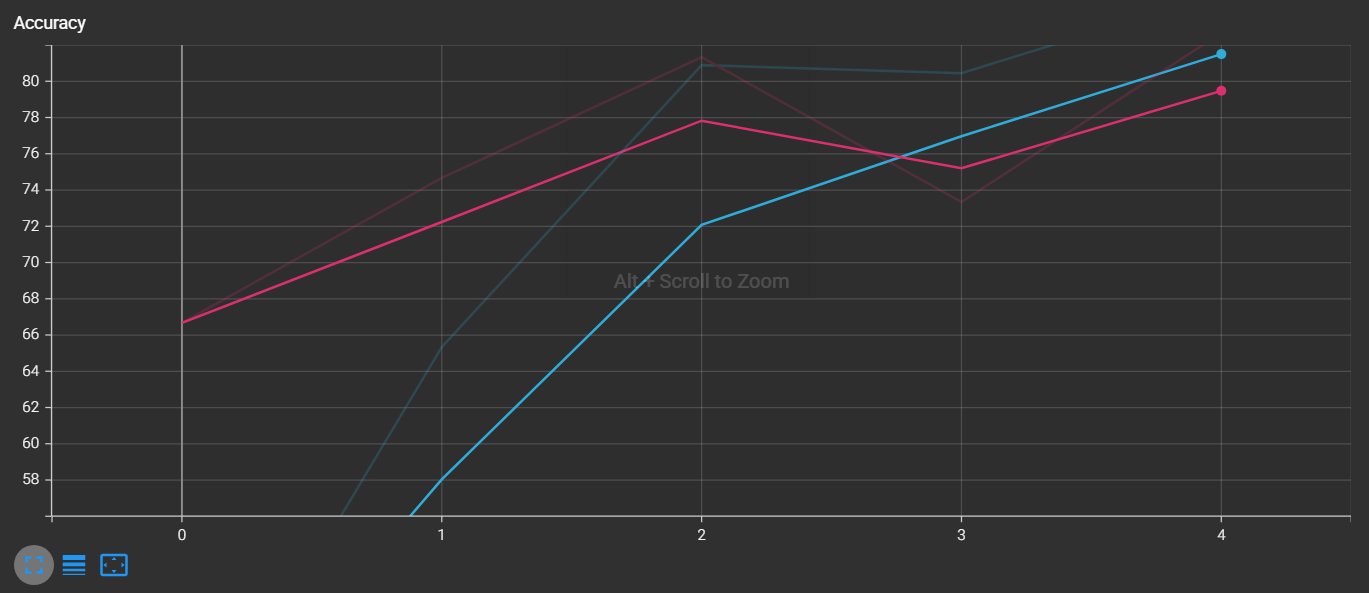
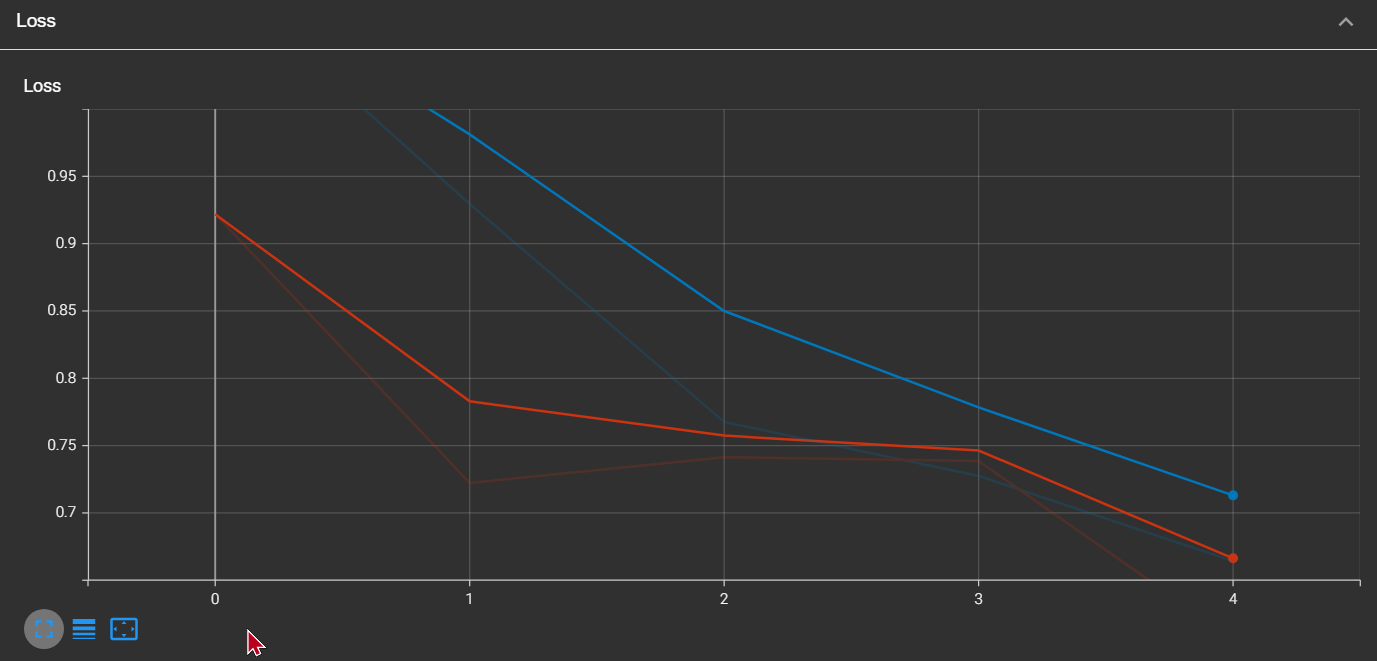
![Jul13_18-23-53_Youssef-PC (1).png](<attachment:Jul13_18-23-53_Youssef-PC (1).png>)


## 6. Create a helper function to build `SummaryWriter()` instances

The `SummaryWriter()` class logs various information to a directory specified by the `log_dir` parameter.

How about we make a helper function to create a custom directory per experiment?

In essence, each experiment gets its own logs directory.

For example, say we'd like to track things like:

- **Experiment date/timestamp** - when did the experiment take place?
- **Experiment name** - is there something we'd like to call the experiment?
- **Model name** - what model was used?
- **Extra** - should anything else be tracked?

You could track almost anything here and be as creative as you want but these should be enough to start.

Let's create a helper function called `create_writer()` that produces a `SummaryWriter()` instance tracking to a custom `log_dir`.

Ideally, we'd like the `log_dir` to be something like:

`runs/YYYY-MM-DD/experiment_name/model_name/extra`

Where `YYYY-MM-DD` is the date the experiment was run (you could add the time if you wanted to as well).


In [19]:
from torch.utils.tensorboard import SummaryWriter

def create_writer(experiment_name: str, 
                    model_name: str, 
                    extra: str=None) -> SummaryWriter:
    """Creates a torch.utils.tensorboard.writer.SummaryWriter() instance saving to a specific log_dir.

    log_dir is a combination of runs/timestamp/experiment_name/model_name/extra.

    Where timestamp is the current date in YYYY-MM-DD format.

    Args:
        experiment_name (str): Name of experiment.
        model_name (str): Name of model.
        extra (str, optional): Anything extra to add to the directory. Defaults to None.

    Returns:
        torch.utils.tensorboard.writer.SummaryWriter(): Instance of a writer saving to log_dir.

    Example usage:
        # Create a writer saving to "runs/2022-06-04/data_10_percent/effnetb2/5_epochs/"
        writer = create_writer(experiment_name="data_10_percent",
                                model_name="effnetb2",
                                extra="5_epochs")
        # The above is the same as:
        writer = SummaryWriter(log_dir="runs/2022-06-04/data_10_percent/effnetb2/5_epochs/")
    """
    from datetime import datetime
    import os

    # Get timestamp of current date (all experiments on certain day live in same folder)
    timestamp = datetime.now().strftime("%Y-%m-%d") # returns current date in YYYY-MM-DD format

    if extra:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
        
    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

### 6.1 Update the `train()` function to include a `writer` parameter

Our `create_writer()` function works fantastic.

How about we give our `train()` function the ability to take in a `writer` parameter so we actively update the `SummaryWriter()` instance we're using each time we call `train()`.

For example, say we're running a series of experiments, calling `train()` multiple times for multiple different models, it would be good if each experiment used a different `writer`.

One `writer` per experiment = one logs directory per experiment.

To adjust the `train()` function we'll add a `writer` parameter to the function and then we'll add some code to see if there's a `writer` and if so, we'll track our information there.

> See changes in train() function in going_modular folder, in the engine.py file.


## 7. Setting up a series of modelling experiments

It's to step things up a notch.

Previously we've been running various experiments and inspecting the results one by one.

But what if we could run multiple experiments and then inspect the results all together?

You in?

C'mon, let's go.


### 7.1 What kind of experiments should you run?

That's the million dollar question in machine learning.

Because there's really no limit to the experiments you can run.

Such a freedom is why machine learning is so exciting and terrifying at the same time.

This is where you'll have to put on your scientist coat and remember the machine learning practitioner's motto: _experiment, experiment, experiment!_

Every hyperparameter stands as a starting point for a different experiment:

- Change the number of **epochs**.
- Change the number of **layers/hidden units**.
- Change the amount of **data**.
- Change the **learning rate**.
- Try different kinds of **data augmentation**.
- Choose a different **model architecture**.

With practice and running many different experiments, you'll start to build an intuition of what _might_ help your model.

I say _might_ on purpose because there's no guarantee.

But generally, in light of [_The Bitter Lesson_](http://www.incompleteideas.net/IncIdeas/BitterLesson.html) (I've mentioned this twice now because it's an important essay in the world of AI), generally the bigger your model (more learnable parameters) and the more data you have (more opportunities to learn), the better the performance.

However, when you're first approaching a machine learning problem: start small and if something works, scale it up.

Your first batch of experiments should take no longer than a few seconds to a few minutes to run.

The quicker you can experiment, the faster you can work out what _doesn't_ work, in turn, the faster you can work out what _does_ work.


### 7.2 What experiments are we going to run?

Our goal is to improve the model powering FoodVision Mini without it getting too big.

In essence, our ideal model achieves a high level of test set accuracy (90%+) but doesn't take too long to train/perform inference (make predictions).

We've got plenty of options but how about we keep things simple?

Let's try a combination of:

1. A different amount of data (10% of Pizza, Steak, Sushi vs. 20%)
2. A different model ([`torchvision.models.efficientnet_b0`](https://pytorch.org/vision/stable/generated/torchvision.models.efficientnet_b0.html#torchvision.models.efficientnet_b0) vs. [`torchvision.models.efficientnet_b2`](https://pytorch.org/vision/stable/generated/torchvision.models.efficientnet_b2.html#torchvision.models.efficientnet_b2))
3. A different training time (5 epochs vs. 10 epochs)

Breaking these down we get:

| Experiment number | Training Dataset                  | Model (pretrained on ImageNet) | Number of epochs |
| ----------------- | --------------------------------- | ------------------------------ | ---------------- |
| 1                 | Pizza, Steak, Sushi 10% percent   | EfficientNetB0                 | 5                |
| 2                 | Pizza, Steak, Sushi 10% percent   | _EfficientNetB2_               | 5                |
| 3                 | Pizza, Steak, Sushi 10% percent   | EfficientNetB0                 | 10               |
| 4                 | Pizza, Steak, Sushi 10% percent   | _EfficientNetB2_               | 10               |
| 5                 | Pizza, Steak, Sushi _20_% percent | EfficientNetB0                 | 5                |
| 6                 | Pizza, Steak, Sushi _20_% percent | _EfficientNetB2_               | 5                |
| 7                 | Pizza, Steak, Sushi _20_% percent | EfficientNetB0                 | 10               |
| 8                 | Pizza, Steak, Sushi _20_% percent | _EfficientNetB2_               | 10               |

Notice how we're slowly scaling things up.

With each experiment we slowly increase the amount of data, the model size and the length of training.

By the end, experiment 8 will be using double the data, double the model size and double the length of training compared to experiment 1.

> **Note:** I want to be clear that there truly is no limit to amount of experiments you can run. What we've designed here is only a very small subset of options. However, you can't test _everything_ so best to try a few things to begin with and then follow the ones which work the best.
>
> And as a reminder, the datasets we're using are a subset of the [Food101 dataset](https://pytorch.org/vision/stable/generated/torchvision.datasets.Food101.html#torchvision.datasets.Food101) (3 classes, pizza, steak, suhsi, instead of 101) and 10% and 20% of the images rather than 100%. If our experiments work, we could start to run more on more data (though this will take longer to compute). You can see how the datasets were created via the [`04_custom_data_creation.ipynb` notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb).


### 7.3 Download different datasets

Before we start running our series of experiments, we need to make sure our datasets are ready.

We'll need two forms of a training set:

1. A training set with **10% of the data** of Food101 pizza, steak, sushi images (we've already created this above but we'll do it again for completeness).
2. A training set with **20% of the data** of Food101 pizza, steak, sushi images.

For consistency, all experiments will use the same testing dataset (the one from the 10% data split).

We'll start by downloading the various datasets we need using the `download_data()` function we created earlier.

Both datasets are available from the course GitHub:

1. [Pizza, steak, sushi 10% training data](https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip).
2. [Pizza, steak, sushi 20% training data](https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip).


In [20]:
# Download 10 percent and 20 percent training data (if necessary)
data_10_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                    destination="pizza_steak_sushi")

data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                    destination="pizza_steak_sushi_20_percent")

[INFO] data\pizza_steak_sushi directory exists, skipping download.
[INFO] Did not find data\pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


In [22]:
# Setup training directory (test data unchanged!!)
TRAIN_DIR_10 = data_10_percent_path/"train"
TRAIN_DIR_20 = data_20_percent_path/"train"

# Setup testing directory paths (note: use the same test dataset for both to compare the results)
TEST_DIR = data_10_percent_path / "test"

# Check the directories
print(f"Training directory 10%: {TRAIN_DIR_10}")
print(f"Training directory 20%: {TRAIN_DIR_20}")
print(f"Testing directory: {TEST_DIR}")

Training directory 10%: data\pizza_steak_sushi\train
Training directory 20%: data\pizza_steak_sushi_20_percent\train
Testing directory: data\pizza_steak_sushi\test


### 7.4 Transform Datasets and create DataLoaders

Next we'll create a series of transforms to prepare our images for our model(s).

To keep things consistent, we'll manually create a transform (just like we did above) and use the same transform across all of the datasets.

The transform will:

1. Resize all the images (we'll start with 224, 224 but this could be changed).
2. Turn them into tensors with values between 0 & 1.
3. Normalize them in way so their distributions are inline with the ImageNet dataset (we do this because our models from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) have been pretrained on ImageNet).


In [23]:
from torchvision import transforms

# Create a transform to normalize data distribution to be inline with ImageNet
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], # values per colour channel [red, green, blue]
                                std=[0.229, 0.224, 0.225]) # values per colour channel [red, green, blue]

# Compose transforms into a pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Resize the images
    transforms.ToTensor(), # 2. Turn the images into tensors with values between 0 & 1
    normalize # 3. Normalize the images so their distributions match the ImageNet dataset 
])

Transform ready!

Now let's create our DataLoaders using the `create_dataloaders()` function from `data_setup.py` we created in [05. PyTorch Going Modular section 2](https://www.learnpytorch.io/05_pytorch_going_modular/#2-create-datasets-and-dataloaders-data_setuppy).

We'll create the DataLoaders with a batch size of 32.

For all of our experiments we'll be using the same `test_dataloader` (to keep comparisons consistent).


In [25]:
from going_modular.data_setup import create_dataloader

BATCH_SIZE = 32

# Create 10% training and test DataLoaders
train_dataloader_10_percent, test_dataloader, class_names = create_dataloader(train_dir=TRAIN_DIR_10,
                                                                                        test_dir=TEST_DIR, 
                                                                                        transform=simple_transform,
                                                                                        batch_size=BATCH_SIZE
                                                                                    )

# Create 20% training and test data DataLoders
train_dataloader_20_percent, test_dataloader, class_names = create_dataloader(train_dir=TRAIN_DIR_20,
                                                                                        test_dir=TEST_DIR,
                                                                                        transform=simple_transform,
                                                                                        batch_size=BATCH_SIZE
                                                                                    )

# Find the number of samples/batches per dataloader (using the same test_dataloader for both experiments)
print(f"Number of batches of size {BATCH_SIZE} in 10 percent training data: {len(train_dataloader_10_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 20 percent training data: {len(train_dataloader_20_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in testing data: {len(test_dataloader)} (all experiments will use the same test set)")
print(f"Number of classes: {len(class_names)}, class names: {class_names}")

Number of batches of size 32 in 10 percent training data: 8
Number of batches of size 32 in 20 percent training data: 15
Number of batches of size 32 in testing data: 3 (all experiments will use the same test set)
Number of classes: 3, class names: ['pizza', 'steak', 'sushi']


### 7.5 Create feature extractor models

Time to start building our models.

We're going to create two feature extractor models:

1. [`torchvision.models.efficientnet_b0()`](https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b0.html) pretrained backbone + custom classifier head (EffNetB0 for short).
2. [`torchvision.models.efficientnet_b2()`](https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b2.html) pretrained backbone + custom classifier head (EffNetB2 for short).

To do this, we'll freeze the base layers (the feature layers) and update the model's classifier heads (output layers) to suit our problem just like we did in [06. PyTorch Transfer Learning section 3.4](https://www.learnpytorch.io/06_pytorch_transfer_learning/#34-freezing-the-base-model-and-changing-the-output-layer-to-suit-our-needs).

We saw in the previous chapter the `in_features` parameter to the classifier head of EffNetB0 is `1280` (the backbone turns the input image into a feature vector of size `1280`).

Since EffNetB2 has a different number of layers and parameters, we'll need to adapt it accordingly.

> **Note:** Whenever you use a different model, one of the first things you should inspect is the input and output shapes. That way you'll know how you'll have to prepare your input data/update the model to have the correct output shape.

We can find the input and output shapes of EffNetB2 using [`torchinfo.summary()`](https://github.com/TylerYep/torchinfo) and passing in the `input_size=(32, 3, 224, 224)` parameter (`(32, 3, 224, 224)` is equivalent to `(batch_size, color_channels, height, width)`, i.e we pass in an example of what a single batch of data would be to our model).

> **Note:** Many modern models can handle input images of varying sizes thanks to [`torch.nn.AdaptiveAvgPool2d()`](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html) layer, this layer adaptively adjusts the `output_size` of a given input as required. You can try this out by passing different size input images to `torchinfo.summary()` or to your own models using the layer.

To find the required input shape to the final layer of EffNetB2, let's:

1. Create an instance of `torchvision.models.efficientnet_b2(pretrained=True)`.
2. See the various input and output shapes by running `torchinfo.summary()`.
3. Print out the number of `in_features` by inspecting `state_dict()` of the classifier portion of EffNetB2 and printing the length of the weight matrix.
   - **Note:** You could also just inspect the output of `effnetb2.classifier`.


<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/07-effnetb2-unfrozen-summary-output.png" alt="output of torchinfo.summary() when passed our effnetb2 model with all layers trainable and default classifier head" width=900/>

_Model summary of EffNetB2 feature extractor model with all layers unfrozen (trainable) and default classifier head from ImageNet pretraining._

Now we know the required number of `in_features` for the EffNetB2 model, let's create a couple of helper functions to setup our EffNetB0 and EffNetB2 feature extractor models.

We want these functions to:

1. Get the base model from `torchvision.models`
2. Freeze the base layers in the model (set `requires_grad=False`)
3. Set the random seeds (we don't _need_ to do this but since we're running a series of experiments and initalizing a new layer with random weights, we want the randomness to be similar for each experiment)
4. Change the classifier head (to suit our problem)
5. Give the model a name (e.g. "effnetb0" for EffNetB0)


In [32]:
import torchvision
from torch import nn

OUT_FEATURES = len(class_names)

def create_effnetb0():
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights= weights)
    
    for param in model.features.parameters():
        param.requires_grad = False
        
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    ).to(device)
    
    # Give the model a name
    model.name = "effnetb0"
    print(f"\033[32m[INFO] Created new {model.name} model.\033[0m")
    
    return model

def create_effnetb2():
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights= weights)
    
    for param in model.features.parameters():
        param.requires_grad = False
        
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features=1408, out_features=OUT_FEATURES)
    ).to(device)
    
    # Give the model a name
    model.name = "effnetb2"
    print(f"\033[32m[INFO] Created new {model.name} model.\033[0m")
    
    return model

In [33]:
effnetb0 = create_effnetb0() 

# Get an output summary of the layers in our EffNetB0 feature extractor model (uncomment to view full output)
summary(model=effnetb0, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

[INFO] Created new effnetb0 model.


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [34]:
effnetb2 = create_effnetb2() 

# Get an output summary of the layers in our EffNetB0 feature extractor model (uncomment to view full output)
summary(model=effnetb2, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

[INFO] Created new effnetb2 model.


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

Looking at the outputs of the summaries, it seems the EffNetB2 backbone has nearly double the amount of parameters as EffNetB0.

| Model          | Total parameters (before freezing/changing head) | Total parameters (after freezing/changing head) | Total trainable parameters (after freezing/changing head) |
| -------------- | ------------------------------------------------ | ----------------------------------------------- | --------------------------------------------------------- |
| EfficientNetB0 | 5,288,548                                        | 4,011,391                                       | 3,843                                                     |
| EfficientNetB2 | 9,109,994                                        | 7,705,221                                       | 4,227                                                     |

This gives the backbone of the EffNetB2 model more opportunities to form a representation of our pizza, steak and sushi data.

However, the trainable parameters for each model (the classifier heads) aren't very different.

Will these extra parameters lead to better results?

We'll have to wait and see...

> **Note:** In the spirit of experimenting, you really could try almost any model from `torchvision.models` in a similar fashion to what we're doing here. I've only chosen EffNetB0 and EffNetB2 as examples. Perhaps you might want to throw something like `torchvision.models.convnext_tiny()` or `torchvision.models.convnext_small()` into the mix.


### 7.6 Create experiments and set up training code

We've prepared our data and prepared our models, the time has come to setup some experiments!

We'll start by creating two lists and a dictionary:

1. A list of the number of epochs we'd like to test (`[5, 10]`)
2. A list of the models we'd like to test (`["effnetb0", "effnetb2"]`)
3. A dictionary of the different training DataLoaders


In [31]:
# 1. Create epochs list
num_epochs = [5, 10]

# 2. Create models list
models = ["effnetb0", "effnetb2"]

# 3. Create dataloaders dict
train_dataloaders = {"data_10": train_dataloader_10_percent,
                    "data_20" : train_dataloader_20_percent}

Lists and dictionary created!

Now we can write code to iterate through each of the different options and try out each of the different combinations.

We'll also save the model at the end of each experiment so later on we can load back in the best model and use it for making predictions.

Specifically, let's go through the following steps:

1. Set the random seeds (so our experiment results are reproducible, in practice, you might run the same experiment across ~3 different seeds and average the results).
2. Keep track of different experiment numbers (this is mostly for pretty print outs).
3. Loop through the `train_dataloaders` dictionary items for each of the different training DataLoaders.
4. Loop through the list of epoch numbers.
5. Loop through the list of different model names.
6. Create information print outs for the current running experiment (so we know what's happening).
7. Check which model is the target model and create a new EffNetB0 or EffNetB2 instance (we create a new model instance each experiment so all models start from the same standpoint).
8. Create a new loss function (`torch.nn.CrossEntropyLoss()`) and optimizer (`torch.optim.Adam(params=model.parameters(), lr=0.001)`) for each new experiment.
9. Train the model with the modified `train()` function passing the appropriate details to the `writer` parameter.
10. Save the trained model with an appropriate file name to file with `save_model()` from [`utils.py`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/going_modular/utils.py).

We can also use the `%%time` magic to see how long all of our experiments take together in a single Jupyter/Google Colab cell.

Let's do it!


In [ ]:
%%time
from going_modular.utils import save_model
from going_modular.engine import train

# ANSI escape codes for colors
colors = {
    # Standard colors
    "black": "\033[30m",
    "red": "\033[31m",
    "green": "\033[32m",
    "yellow": "\033[33m",
    "blue": "\033[34m",
    "magenta": "\033[35m",
    "cyan": "\033[36m",
    "white": "\033[37m",

    # Bright colors
    "bright_black": "\033[90m",
    "bright_red": "\033[91m",
    "bright_green": "\033[92m",
    "bright_yellow": "\033[93m",
    "bright_blue": "\033[94m",
    "bright_magenta": "\033[95m",
    "bright_cyan": "\033[96m",
    "bright_white": "\033[97m",

    # Reset
    "reset": "\033[0m"
}

# 1. Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# 2. Keep track of experiment numbers
experiment_number = 0

# 3. Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():

    # 4. Loop through each number of epochs
    for epochs in num_epochs: 

        # 5. Loop through each model name and create a new model based on the name
        for model_name in models:

            # 6. Create information print outs
            experiment_number += 1
            print(f"{colors['cyan']}[INFO] Experiment number: {experiment_number}{colors['reset']}")
            print(f"{colors['magenta']}[INFO] Model: {model_name}{colors['reset']}")
            print(f"{colors['yellow']}[INFO] DataLoader: {dataloader_name}{colors['reset']}")
            print(f"{colors['blue']}[INFO] Number of epochs: {epochs}{colors['reset']}") 
            
            # 7. Select model
            model = create_effnetb0().to(device) if model_name == "effnetb0" else create_effnetb2().to(device)
            
            # 8. Create a new loss and optimizer for every model
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
            
            # 9. Train target model with target dataloaders and track experiments
            train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=epochs,
                device=device,
                writer= create_writer(experiment_name=dataloader_name,
                                    model_name=model_name,
                                    extra=f"{epochs}_epochs"))
            
            # 10. Save the model to file so we can get back the best model
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,
                        target_dir="models",
                        model_name=save_filepath)
            
            print("\033[31m" + "-"*50 + "\n" + "\033[0m")
            

[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data_10
[INFO] Number of epochs: 5
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs\2025-07-13\data_10\effnetb0\5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Looked at 0/225 samples
Looked at 64/225 samples
Looked at 128/225 samples
Looked at 192/225 samples


Train loss: 1.03044 | Train accuracy: 50.22%
Test loss: 0.87275 | Test accuracy: 74.67%


Looked at 0/225 samples
Looked at 64/225 samples
Looked at 128/225 samples
Looked at 192/225 samples


Train loss: 0.85098 | Train accuracy: 72.89%
Test loss: 0.69679 | Test accuracy: 86.67%


Looked at 0/225 samples
Looked at 64/225 samples
Looked at 128/225 samples
Looked at 192/225 samples


Train loss: 0.73982 | Train accuracy: 79.56%
Test loss: 0.68199 | Test accuracy: 81.33%


Looked at 0/225 samples
Looked at 64/225 samples
Looked at 128/225 samples
Looked at 192/225 samples


Train loss: 0.73464 | Train accuracy: 78.67%
Test loss: 0.67900 | Test accuracy: 81.33%


Looked at 0/225 samples
Looked at 64/225 samples
Looked at 128/225 samples
Looked at 192/225 samples


Train loss: 0.60057 | Train accuracy: 87.56%
Test loss: 0.56647 | Test accuracy: 86.67%


[INFO] ✅ Model saved to: models\07_

  0%|          | 0/5 [00:00<?, ?it/s]

Looked at 0/225 samples
Looked at 64/225 samples
Looked at 128/225 samples
Looked at 192/225 samples


Train loss: 1.03589 | Train accuracy: 45.33%
Test loss: 0.97598 | Test accuracy: 68.00%


Looked at 0/225 samples
Looked at 64/225 samples
Looked at 128/225 samples
Looked at 192/225 samples


Train loss: 0.95997 | Train accuracy: 55.11%
Test loss: 0.87613 | Test accuracy: 72.00%


Looked at 0/225 samples
Looked at 64/225 samples
Looked at 128/225 samples
Looked at 192/225 samples


Train loss: 0.76814 | Train accuracy: 78.22%
Test loss: 0.73892 | Test accuracy: 89.33%


Looked at 0/225 samples
Looked at 64/225 samples
Looked at 128/225 samples
Looked at 192/225 samples


Train loss: 0.79180 | Train accuracy: 80.89%
Test loss: 0.68627 | Test accuracy: 88.00%


Looked at 0/225 samples
Looked at 64/225 samples
Looked at 128/225 samples
Looked at 192/225 samples


Train loss: 0.66645 | Train accuracy: 87.56%
Test loss: 0.69576 | Test accuracy: 86.67%


[INFO] ✅ Model saved to: models\07_

  0%|          | 0/10 [00:00<?, ?it/s]

Looked at 0/225 samples
Looked at 64/225 samples
Looked at 128/225 samples
Looked at 192/225 samples


Train loss: 1.11526 | Train accuracy: 41.33%
Test loss: 0.89830 | Test accuracy: 77.33%


Looked at 0/225 samples
Looked at 64/225 samples
Looked at 128/225 samples
Looked at 192/225 samples


Train loss: 0.90224 | Train accuracy: 69.78%
Test loss: 0.81342 | Test accuracy: 76.00%


Looked at 0/225 samples
Looked at 64/225 samples
Looked at 128/225 samples
Looked at 192/225 samples


Train loss: 0.75387 | Train accuracy: 83.56%
Test loss: 0.72248 | Test accuracy: 84.00%


Looked at 0/225 samples
Looked at 64/225 samples
Looked at 128/225 samples
Looked at 192/225 samples


Train loss: 0.62799 | Train accuracy: 83.56%
Test loss: 0.69948 | Test accuracy: 81.33%


Looked at 0/225 samples
Looked at 64/225 samples
Looked at 128/225 samples
Looked at 192/225 samples


Train loss: 0.67835 | Train accuracy: 78.22%
Test loss: 0.66394 | Test accuracy: 81.33%


Looked at 0/225 samples
Looked at 6

  0%|          | 0/10 [00:00<?, ?it/s]

Looked at 0/225 samples
Looked at 64/225 samples
Looked at 128/225 samples
Looked at 192/225 samples


Train loss: 1.06497 | Train accuracy: 53.78%
Test loss: 0.91620 | Test accuracy: 76.00%


Looked at 0/225 samples
Looked at 64/225 samples
Looked at 128/225 samples
Looked at 192/225 samples


Train loss: 0.89072 | Train accuracy: 77.33%
Test loss: 0.84172 | Test accuracy: 76.00%


Looked at 0/225 samples
Looked at 64/225 samples
Looked at 128/225 samples
Looked at 192/225 samples


Train loss: 0.78487 | Train accuracy: 87.56%
Test loss: 0.73048 | Test accuracy: 85.33%


Looked at 0/225 samples
Looked at 64/225 samples
Looked at 128/225 samples
Looked at 192/225 samples


Train loss: 0.68348 | Train accuracy: 87.56%
Test loss: 0.71107 | Test accuracy: 86.67%


Looked at 0/225 samples
Looked at 64/225 samples
Looked at 128/225 samples
Looked at 192/225 samples


Train loss: 0.63912 | Train accuracy: 85.78%
Test loss: 0.63018 | Test accuracy: 90.67%


Looked at 0/225 samples
Looked at 6

  0%|          | 0/5 [00:00<?, ?it/s]

Looked at 0/450 samples
Looked at 64/450 samples
Looked at 128/450 samples
Looked at 192/450 samples
Looked at 256/450 samples
Looked at 320/450 samples
Looked at 384/450 samples
Looked at 28/450 samples


Train loss: 0.95276 | Train accuracy: 62.00%
Test loss: 0.66723 | Test accuracy: 92.00%


Looked at 0/450 samples
Looked at 64/450 samples
Looked at 128/450 samples
Looked at 192/450 samples
Looked at 256/450 samples
Looked at 320/450 samples
Looked at 384/450 samples
Looked at 28/450 samples


Train loss: 0.71330 | Train accuracy: 77.11%
Test loss: 0.56663 | Test accuracy: 93.33%


Looked at 0/450 samples
Looked at 64/450 samples
Looked at 128/450 samples
Looked at 192/450 samples
Looked at 256/450 samples
Looked at 320/450 samples
Looked at 384/450 samples
Looked at 28/450 samples


Train loss: 0.57479 | Train accuracy: 85.33%
Test loss: 0.45320 | Test accuracy: 90.67%


Looked at 0/450 samples
Looked at 64/450 samples
Looked at 128/450 samples
Looked at 192/450 samples
Looked at 2

  0%|          | 0/5 [00:00<?, ?it/s]

Looked at 0/450 samples
Looked at 64/450 samples
Looked at 128/450 samples
Looked at 192/450 samples
Looked at 256/450 samples
Looked at 320/450 samples
Looked at 384/450 samples
Looked at 28/450 samples


Train loss: 1.01125 | Train accuracy: 52.00%
Test loss: 0.80175 | Test accuracy: 86.67%


Looked at 0/450 samples
Looked at 64/450 samples
Looked at 128/450 samples
Looked at 192/450 samples
Looked at 256/450 samples
Looked at 320/450 samples
Looked at 384/450 samples
Looked at 28/450 samples


Train loss: 0.72927 | Train accuracy: 77.11%
Test loss: 0.69831 | Test accuracy: 86.67%


Looked at 0/450 samples
Looked at 64/450 samples
Looked at 128/450 samples
Looked at 192/450 samples
Looked at 256/450 samples
Looked at 320/450 samples
Looked at 384/450 samples
Looked at 28/450 samples


Train loss: 0.58334 | Train accuracy: 87.33%
Test loss: 0.59102 | Test accuracy: 89.33%


Looked at 0/450 samples
Looked at 64/450 samples
Looked at 128/450 samples
Looked at 192/450 samples
Looked at 2

  0%|          | 0/10 [00:00<?, ?it/s]

Looked at 0/450 samples
Looked at 64/450 samples
Looked at 128/450 samples
Looked at 192/450 samples
Looked at 256/450 samples
Looked at 320/450 samples
Looked at 384/450 samples
Looked at 28/450 samples


Train loss: 0.94945 | Train accuracy: 58.67%
Test loss: 0.74105 | Test accuracy: 85.33%


Looked at 0/450 samples
Looked at 64/450 samples
Looked at 128/450 samples
Looked at 192/450 samples
Looked at 256/450 samples
Looked at 320/450 samples
Looked at 384/450 samples
Looked at 28/450 samples


Train loss: 0.65982 | Train accuracy: 84.00%
Test loss: 0.57379 | Test accuracy: 89.33%


Looked at 0/450 samples
Looked at 64/450 samples
Looked at 128/450 samples
Looked at 192/450 samples
Looked at 256/450 samples
Looked at 320/450 samples
Looked at 384/450 samples
Looked at 28/450 samples


Train loss: 0.52154 | Train accuracy: 87.33%
Test loss: 0.44927 | Test accuracy: 92.00%


Looked at 0/450 samples
Looked at 64/450 samples
Looked at 128/450 samples
Looked at 192/450 samples
Looked at 2

  0%|          | 0/10 [00:00<?, ?it/s]

Looked at 0/450 samples
Looked at 64/450 samples
Looked at 128/450 samples
Looked at 192/450 samples
Looked at 256/450 samples
Looked at 320/450 samples
Looked at 384/450 samples
Looked at 28/450 samples


Train loss: 0.97638 | Train accuracy: 51.78%
Test loss: 0.79793 | Test accuracy: 86.67%


Looked at 0/450 samples
Looked at 64/450 samples
Looked at 128/450 samples
Looked at 192/450 samples
Looked at 256/450 samples
Looked at 320/450 samples
Looked at 384/450 samples
Looked at 28/450 samples


Train loss: 0.74884 | Train accuracy: 75.78%
Test loss: 0.65739 | Test accuracy: 90.67%


Looked at 0/450 samples
Looked at 64/450 samples
Looked at 128/450 samples
Looked at 192/450 samples
Looked at 256/450 samples
Looked at 320/450 samples
Looked at 384/450 samples
Looked at 28/450 samples


Train loss: 0.63156 | Train accuracy: 86.22%
Test loss: 0.61187 | Test accuracy: 90.67%


Looked at 0/450 samples
Looked at 64/450 samples
Looked at 128/450 samples
Looked at 192/450 samples
Looked at 2

In [ ]:
%tensorboard -

Reusing TensorBoard on port 6011 (pid 20416), started 4:42:31 ago. (Use '!kill 20416' to kill it.)